In [1]:
%load_ext autoreload
%autoreload 2

import ssm
from ssm import distributions as ssmdist
import jax.numpy as np
import jax.random as npr

from tensorflow_probability.substrates import jax as tfp

In [2]:
import jax.numpy as np
import jax.random as jr
import jax.experimental.optimizers as optimizers
from jax import jit, value_and_grad, vmap
from tqdm.auto import trange

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

In [3]:
from ssm.models.lds import GaussianLDS, GLMLDS
from ssm.distributions.linreg import GaussianLinearRegression
from ssm.distributions.glm import GaussianGLM, PoissonGLM

In [4]:
def random_rotation(seed, n, theta=None):
    
    key1, key2 = jr.split(seed)
    
    if theta is None:
        # Sample a random, slow rotation
        theta = 0.5 * np.pi * jr.uniform(key1)

    if n == 1:
        return jr.uniform(key1) * np.eye(1)

    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    out = np.eye(n)
    out = out.at[:2, :2].set(rot)
    q = np.linalg.qr(jr.uniform(key2, shape=(n, n)))[0]
    return q.dot(out).dot(q.T)


def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    """Utility to visualize the dynamics for a 2 dimensional dynamical system.
    Args
    ----
        dynamics_matrix: 2x2 numpy array. "A" matrix for the system.
        bias_vector: "b" vector for the system. Has size (2,).
        mins: Tuple of minimums for the quiver plot.
        maxs: Tuple of maximums for the quiver plot.
        npts: Number of arrows to show.
        axis: Axis to use for plotting. Defaults to None, and returns a new axis.
        kwargs: keyword args passed to plt.quiver.
    Returns
    -------
        q: quiver object returned by pyplot
    """
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    xy_grid = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
        
    plt.gca().set_aspect(1.0)
    return q

In [5]:
emissions_dim = 10  # num_neurons
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianGLM(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    0.1**2 * np.eye(latent_dim))

emissions_distribution = PoissonGLM(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.ones(emissions_dim))

true_lds = GLMLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

In [6]:
time_bins = 500
key = jr.PRNGKey(0)

import warnings
with warnings.catch_warnings():  # ignore annoying Poisson sampling warning
    warnings.filterwarnings('ignore', category=UserWarning)
    states, data = true_lds.sample(key=key, num_steps=time_bins)

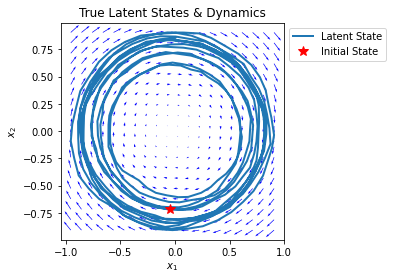

In [7]:
q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue")
plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("True Latent States & Dynamics")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

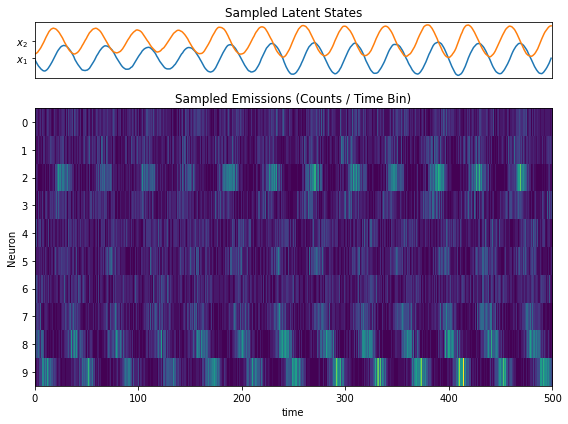

In [8]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states[:, d] + lim * d, '-')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Sampled Latent States")

lim = abs(data).max()
plt.subplot(gs[1])
plt.imshow(data.T, aspect="auto", interpolation="none")
plt.xlabel("time")
plt.xlim(0, time_bins)
plt.yticks(ticks=np.arange(emissions_dim))
plt.ylabel("Neuron")

plt.title("Sampled Emissions (Counts / Time Bin)")
plt.tight_layout()

# Inference

In [165]:
emissions_dim = 10  # num_neurons
latent_dim = 2
seed = jr.PRNGKey(32)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    1.0**2 * np.eye(latent_dim))

emissions_distribution = PoissonGLM(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.ones(emissions_dim))

test_lds = GLMLDS(initial_distribution, 
                  dynamics_distribution,
                  emissions_distribution)

In [211]:
from ssm.inference.lds import laplace_em, _laplace_find_mode

rng = jr.PRNGKey(10)
elbos, fitted_lds, posterior = laplace_em(rng, test_lds, data, num_iters=1000, laplace_mode_fit_method="Adam", num_laplace_mode_iters=10, num_approx_m_iters=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

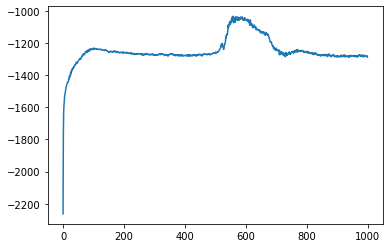

In [212]:
plt.plot(elbos)

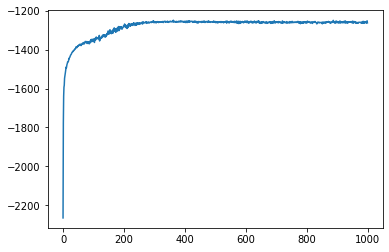

In [208]:
plt.plot(elbos)

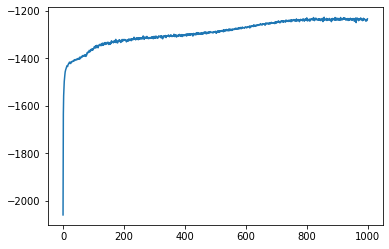

In [206]:
plt.plot(elbos)

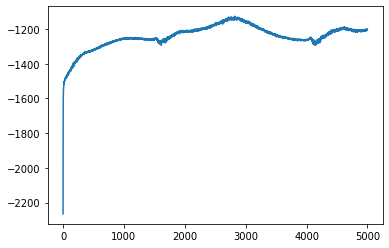

In [200]:
plt.plot(elbos)

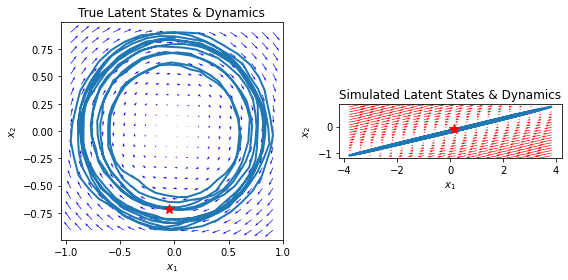

In [213]:
# Posterior Mean
Ex = posterior.mean

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue",
                     axis=axs[0])
axs[0].plot(states[:,0], states[:,1], lw=2)
axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].set_title("True Latent States & Dynamics")

q = plot_dynamics_2d(fitted_lds._dynamics_distribution.weights, 
                     bias_vector=fitted_lds._dynamics_distribution.bias,
                     mins=Ex.min(axis=0),
                     maxs=Ex.max(axis=0),
                     color="red",
                     axis=axs[1])

axs[1].plot(Ex[:,0], posterior.mean[:,1], lw=2)
axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_title("Simulated Latent States & Dynamics")
plt.tight_layout()
plt.show()

In [214]:
# Compute the data predictions
Ex = posterior.mean
C = fitted_lds.emissions_matrix
d = fitted_lds.emissions_bias
# R = fitted_lds.emissions_noise_covariance

Ey = Ex @ C.T + d
Covy = C @ posterior.covariance @ C.T

In [215]:
# basically recover the "true" input to the Poisson GLM
Ey_true = states @ true_lds.emissions_matrix.T + true_lds.emissions_bias

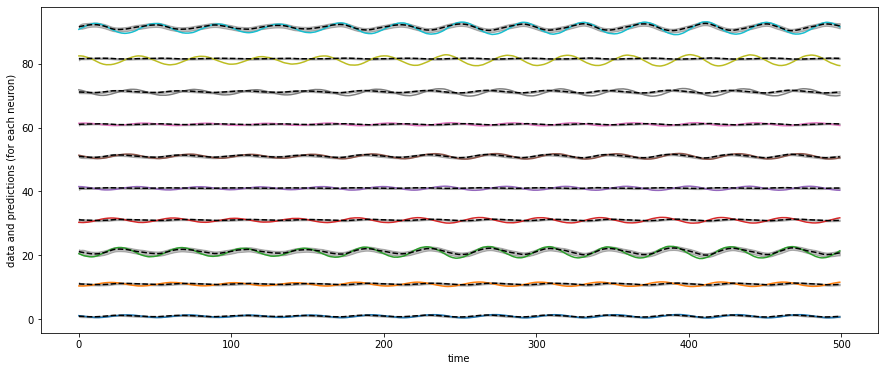

In [216]:
data_dim = data.shape[-1]

plt.figure(figsize=(15, 6))
plt.plot(Ey_true + 10 * np.arange(data_dim))
plt.plot(Ey + 10 * np.arange(data_dim), '--k')
for i in range(data_dim):
  plt.fill_between(np.arange(len(data)),
                   10 * i + Ey[:, i] - 2 * np.sqrt(Covy[:, i, i]),
                   10 * i + Ey[:, i] + 2 * np.sqrt(Covy[:, i, i]), 
                   color='k', alpha=0.25)
plt.xlabel("time")
plt.ylabel("data and predictions (for each neuron)")
plt.show()